# Modeling

## Table of Contents

1. [Data Loading](#data_loading)
2. [Model Choice](#model_choice)
3. [Traning without class balancing](#without_class_balancing)
4. [Class balancing](#class_balancing)
5. [Feature Selection](#feature_selection)
6. [Hyperparameter Tuning](#hyperparameter_tuning)
7. [Other Models](#other_models)
7. [Conclusions](#feature_importance)
8. [Test file](#test_file)

Import libraries and utility functions:

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from kydavra import PearsonCorrelationSelector, PointBiserialCorrSelector
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from utils import evaluate_model

sns.set_style('whitegrid')
sns.set_palette('pastel')

## 1. Data Loading <a class='anchor' id='data_loading'></a>

In [58]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/processed/train.csv')
df_test = pd.read_csv('../data/processed/test.csv')

df.head()

,city_id,city_development_index,gender,experience,last_new_job,training_hours,target,relevant_experience_no,enrolled_university_Part time course,enrolled_university_Unknown,...,company_size_3,company_size_4,company_size_5,company_size_6,company_size_7,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd
0,40,0.776,1,15,5,47,0.0,True,False,False,...,False,True,False,False,False,False,False,False,False,True
1,115,0.789,3,0,0,52,1.0,True,False,True,...,False,False,False,False,False,False,False,False,False,True
2,162,0.767,1,21,4,8,0.0,False,False,False,...,False,True,False,False,False,True,False,False,False,False
3,160,0.920,1,5,1,24,0.0,False,False,False,...,False,True,False,False,False,True,False,False,False,False
4,46,0.762,1,13,5,18,1.0,False,False,False,...,False,False,False,False,True,False,False,False,False,True


### Train test split

In [59]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 2. Model choice <a class='anchor' id='model_choice'></a>

Treating the task as a classification problem, I will use a Random Forest Classifier. Compared to other models, such as Logistic Regression, KNN, SVM or XGBoost, Random Forest is more robust to outliers and does not require the data to be scaled. However, I will also present the results of the other models, so we can compare them.

## 3. Training without Class Balancing <a class='anchor' id='without_class_balancing'></a>

In the previous notebook, it has been shown that the dataset is imbalanced. Let's try to train the model without balancing the classes to see how it performs.

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90      2090
         1.0       0.61      0.35      0.44       514

    accuracy                           0.83      2604
   macro avg       0.73      0.65      0.67      2604
weighted avg       0.81      0.83      0.81      2604

Accuracy Score:
0.8275729646697388


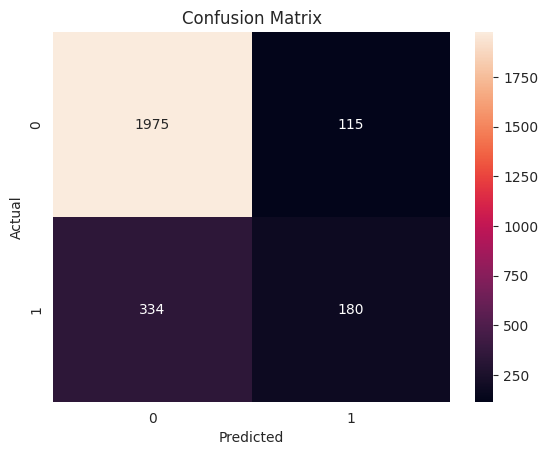

In [60]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

evaluate_model(y_test, y_pred)

## 4. Class Balancing <a class='anchor' id='class_balancing'></a>

I chose SMOTE to balance the classes. SMOTE is an oversampling technique that creates synthetic samples from the minority class. It is a good choice for this problem because it does not create exact copies of the minority class, but rather creates new, slightly different samples. This will help the model to generalize better. <a id='best_model'></a>

In [94]:
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

df = pd.concat([X, y], axis=1)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.91      0.90      2133
         1.0       0.91      0.87      0.89      2117

    accuracy                           0.89      4250
   macro avg       0.89      0.89      0.89      4250
weighted avg       0.89      0.89      0.89      4250

Accuracy Score:
0.8938823529411765


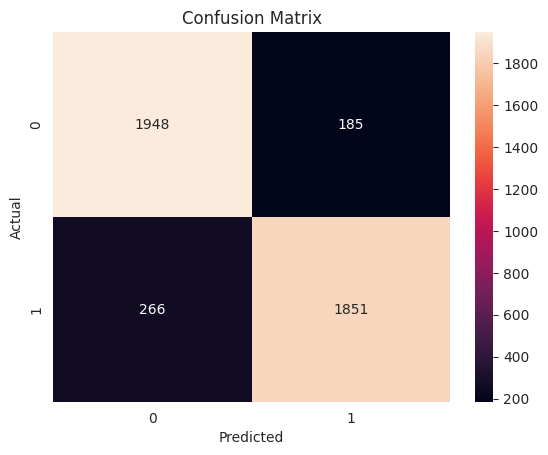

In [63]:
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

evaluate_model(y_test, y_pred)

Thus, perfoming SMOTE on the training set led to a balanced dataset and a more accurate model, as also seen in the confusion matrix.

## 5. Feature Selection <a class='anchor' id='feature_selection'></a>

I chose two correlation based feature selection methods available in the kydavra library.

In [64]:
pearson = PearsonCorrelationSelector()
selected_columns = pearson.select(df, 'target')

selected_columns

[]

In [65]:
point_biserial = PointBiserialCorrSelector()
selected_columns = point_biserial.select(df, 'target')

selected_columns

['city_development_index', 'city_id', 'experience']

Since the pearson correlation selector picked up no columns, I will train the model with the features selected by the point biserial correlation selector.

Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.87      0.82      2133
         1.0       0.86      0.75      0.80      2117

    accuracy                           0.81      4250
   macro avg       0.82      0.81      0.81      4250
weighted avg       0.82      0.81      0.81      4250

Accuracy Score:
0.8127058823529412


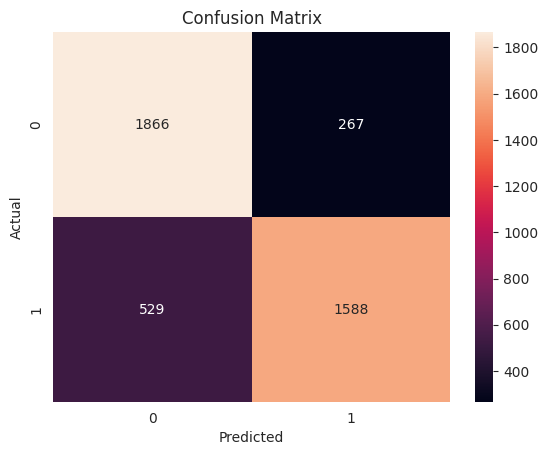

In [66]:
X = df[selected_columns]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rfc_fs = RandomForestClassifier(random_state=42)
rfc_fs.fit(X_train, y_train)
y_pred = rfc_fs.predict(X_test)

evaluate_model(y_test, y_pred)

It seems that the model performed better before feature selection. Thus, I will not take in consideration this step.

In [67]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 6. Hyperparameter Tuning <a class='anchor' id='hyperparameter_tuning'></a>

In [68]:
param_grid = {
  'bootstrap': [True, False],
  'n_estimators': [100, 200, 300, 400, 500],
  'max_depth': [20, 40, 60, 80, 100, None],
  'min_samples_split': [2, 5, 10],
  'min_samples_leaf': [1, 2, 4],
  'max_features': ['sqrt', 'log2', None],
  'criterion': ['gini', 'entropy', 'log_loss']
}


rf = RandomForestClassifier()
halving_search = HalvingGridSearchCV(estimator=rf, param_grid=param_grid, cv=3, factor=2, n_jobs=-1)
halving_search.fit(X_train, y_train)

best_params = halving_search.best_params_

print(f'Best params: {best_params}')

Best params: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}


Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90      2133
         1.0       0.91      0.88      0.89      2117

    accuracy                           0.90      4250
   macro avg       0.90      0.90      0.90      4250
weighted avg       0.90      0.90      0.90      4250

Accuracy Score:
0.896235294117647


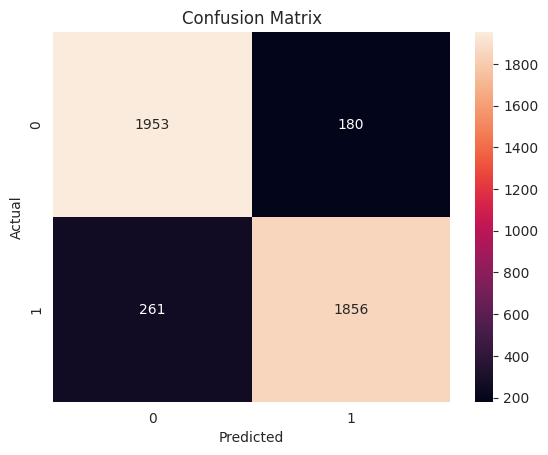

In [79]:
rfc_tuned = RandomForestClassifier(**best_params)

rfc_tuned.fit(X_train, y_train)
y_pred = rfc_tuned.predict(X_test)

evaluate_model(y_test, y_pred)

Based on classification report and confusion matrix, it is clear that hypertunning led to a better model.

In [99]:
model = rfc_tuned

## 7. Other models <a class='anchor' id='other_models'></a>

Besides Random Forest, I also tried Logistic Regression, KNN, SVM and XGBoost for comparison. 

First, I had to scale the data. I chose to use the StandardScaler, which standardizes features by removing the mean and scaling to unit variance.

In [81]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

LogisticRegression
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.90      0.87      2133
         1.0       0.89      0.84      0.86      2117

    accuracy                           0.87      4250
   macro avg       0.87      0.87      0.87      4250
weighted avg       0.87      0.87      0.87      4250

Accuracy Score:
0.8691764705882353


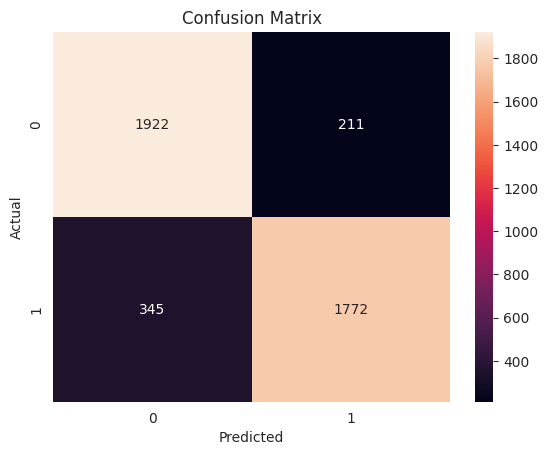

SVC
Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.91      0.89      2133
         1.0       0.91      0.85      0.88      2117

    accuracy                           0.88      4250
   macro avg       0.88      0.88      0.88      4250
weighted avg       0.88      0.88      0.88      4250

Accuracy Score:
0.8828235294117647


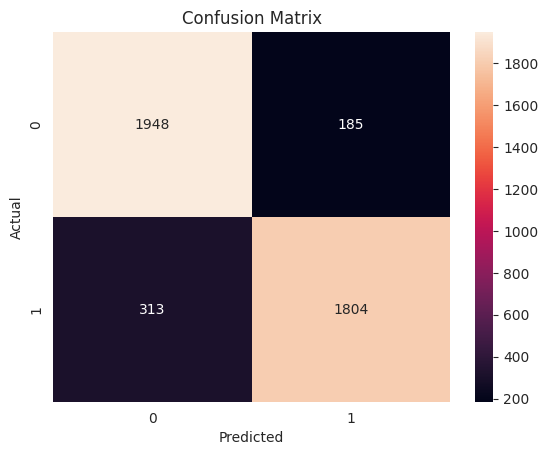

KNeighborsClassifier
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.90      0.87      2133
         1.0       0.89      0.82      0.85      2117

    accuracy                           0.86      4250
   macro avg       0.86      0.86      0.86      4250
weighted avg       0.86      0.86      0.86      4250

Accuracy Score:
0.8604705882352941


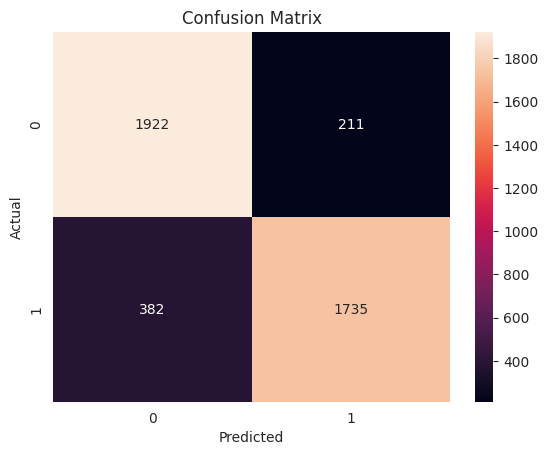

XGBClassifier
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.92      0.90      2133
         1.0       0.92      0.86      0.89      2117

    accuracy                           0.89      4250
   macro avg       0.89      0.89      0.89      4250
weighted avg       0.89      0.89      0.89      4250

Accuracy Score:
0.892


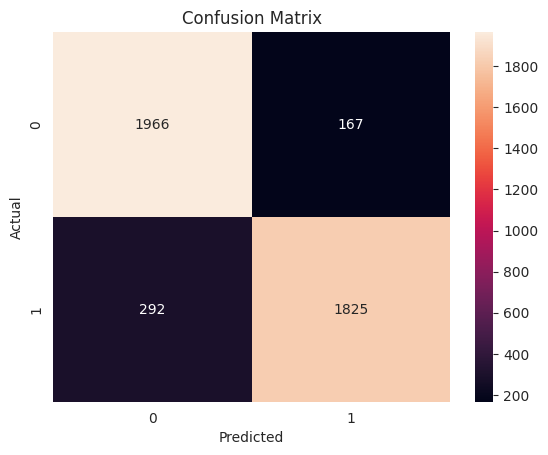

In [82]:
lr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
svc = SVC()
xgb = XGBClassifier()

models = [lr, svc, knn, xgb]

for model in models:
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f'{model.__class__.__name__}')
    evaluate_model(y_test, y_pred)
    

Thus, the best classification model remains the tuned Random Forest Classifier (stats [here](#best_model)).

(I have to mention that I saw that that XGBClassifier also had a similar score and I tried tunning it as well, however it did not perform better than the Random Forest Classifier.)

### Regression*

Since probability is a continuous variable, I also tried to train a regression model. I chose the Random Forest Regressor, an extension of the Random Forest Classifier that predicts the value of a target variable by fitting decision trees on a training set.

In [83]:
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

print('MSE:', mean_squared_error(y_test, y_pred))
print('Score:', rfr.score(X_test, y_test))

MSE: 0.08588866065343173
Score: 0.6564404881137449


In [84]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print('MSE:', mean_squared_error(y_test, y_pred))
print('Score:', lr.score(X_test, y_test))

MSE: 0.11981527913899208
Score: 0.5207320907749793


## 8. Conclusions <a class='anchor' id='conclusions'></a>

Now that we have a trained model, we can see which features are the most important. This will help us to understand the problem better and to identify the most important factors that influence the target variable.

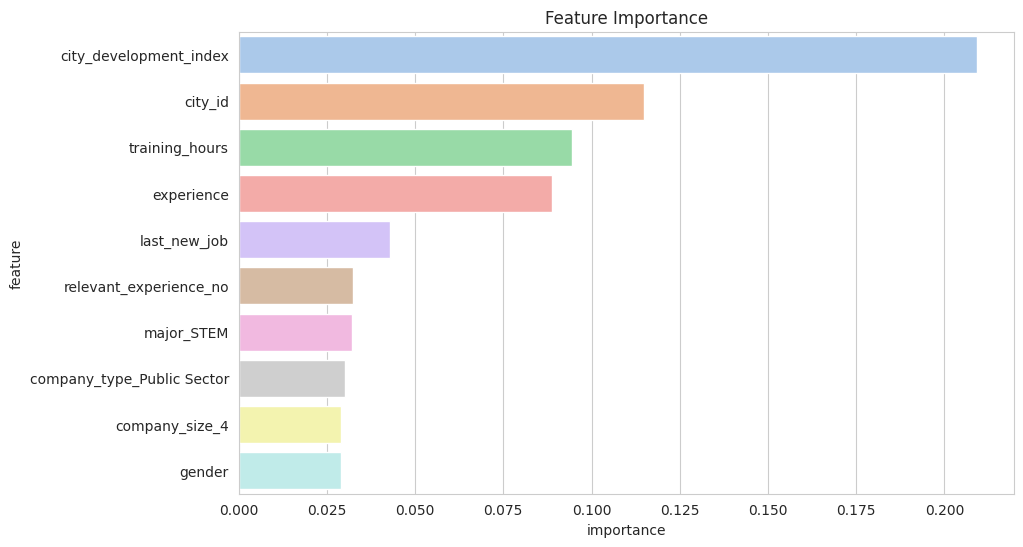

In [100]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
feature_importance.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Feature Importance')
plt.show()

As mentioned previously, the values for city development index and even the city are seem to be the most important factors when determining whether a candidate will be hired or not. Furthermore, it is also reasonable that the time spent on traning and previous experience are also important factors.

In [93]:
print('Top 10 cities with the most number of canddiates looking for a job')
print(df[df['target'] == 1]['city_id'].value_counts().head(10))

Top 10 cities with the most number of canddiates looking for a job
city_id
21     4754
103    1318
114     416
11      336
102     242
16      241
74      163
160     135
101     128
73      113
Name: count, dtype: int64


This makes sense since they are also among the most common values for city in the dataset.

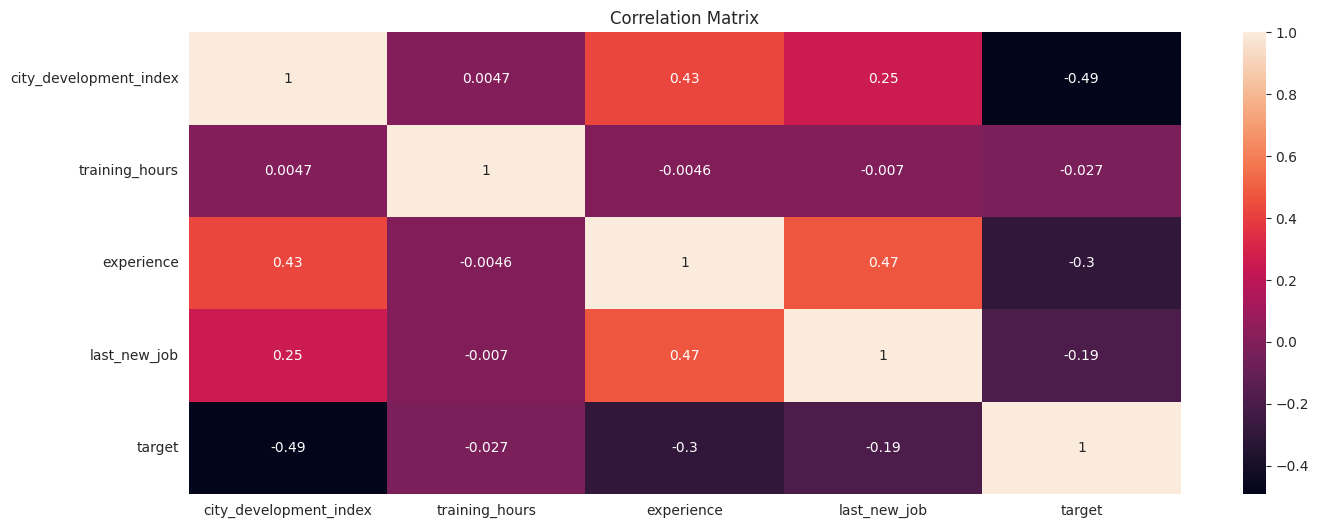

In [104]:
plt.figure(figsize=(16, 6))
sns.heatmap(df[['city_development_index', 'training_hours', 'experience', 'last_new_job', 'target']].corr(), annot=True)
plt.title('Correlation Matrix')
plt.show()

The development index of a city has negative correlation with the target variable, which means that the higher the development index, the lower the chances of a candidate to leave the current job. Traning hours also seem to have a negative correlation, but not as strong as the development index. 

Furthermore, years of experience also seem to have a negative correlation with the target variable. In the dataset, most candidates have 20+ years of experience, among which most of them are not looking for a job change.

Last but not least, only last_new_job seems to have a positive correlation with the target variable - the more years since the last job change, the higher the chances of a candidate to leave the current job.

## 9. Test file <a class='anchor' id='test_file'></a>

Now, for testing purposes, I will use the model to create a submission file for the test set.

In [101]:
y_pred_test = model.predict(df_test)

df_test_raw = pd.read_csv('../data/input/test.csv')
df_submission = pd.DataFrame({'enrollee_id': df_test_raw['enrollee_id'], 'target': y_pred_test})

df_submission.to_csv('../data/output/submission.csv', index=False)